# Ingredient Analysis & Food Substitution Intelligence

- Ingredient text parsing and standardization
- Common ingredient extraction and frequency analysis
- Allergen pattern identification and classification
- Ingredient co-occurrence analysis for recipe suggestions
- Nutritional impact mapping per ingredient
- Ingredient similarity matrices for substitution recommendations
- Allergen-free alternative identification algorithms

**Analysis #3 from NutriFoodBot EDA Roadmap**

## Setup and imports


In [26]:
# Data processing and analysis imports
import pandas as pd
import numpy as np
import warnings
import re
import json
from typing import Union, List, Dict, Optional, Tuple, Any
from collections import Counter
from pathlib import Path
from datetime import datetime

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# HuggingFace datasets library for data loading
from datasets import load_dataset

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure warnings
warnings.filterwarnings('ignore')

## Data Loading

In [27]:
# Load dataset (using 2% sample for detailed nutritional analysis)


try:
    print("Loading 2% sample for detailed nutritional analysis...")
    dataset = load_dataset("parquet", data_files="food.parquet", split="train[:2%]")
    df = dataset.to_pandas()
    
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Basic data quality checks
    print("Null values in key columns:")
    key_columns = ['ingredients_text', 'ingredients', 'nutriments']
    for col in key_columns:
        if col in df.columns:
            null_count = df[col].isnull().sum()
            print(f"  {col}: {null_count} ({null_count/len(df)*100:.1f}%)")
        else:
            print(f"  {col}: Column not found in dataset")
    
    # Display basic info about the dataset
    print(f"\nDataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading 2% sample for detailed nutritional analysis...
Dataset shape: (78896, 110)
Dataset shape: (78896, 110)
Memory usage: 1049.73 MB
Null values in key columns:
  ingredients_text: 0 (0.0%)
  ingredients: 3284 (4.2%)
  nutriments: 945 (1.2%)

Dataset Info:
Shape: (78896, 110)
Columns: ['additives_n', 'additives_tags', 'allergens_tags', 'brands_tags', 'brands', 'categories', 'categories_tags', 'categories_properties', 'checkers_tags', 'ciqual_food_name_tags', 'cities_tags', 'code', 'compared_to_category', 'complete', 'completeness', 'correctors_tags', 'countries_tags', 'created_t', 'creator', 'data_quality_errors_tags', 'data_quality_info_tags', 'data_quality_warnings_tags', 'data_sources_tags', 'ecoscore_data', 'ecoscore_grade', 'ecoscore_score', 'ecoscore_tags', 'editors', 'emb_codes_tags', 'emb_codes', 'entry_dates_tags', 'food_groups_tags', 'generic_name', 'images', 'informers_tags', 'ingredients_analysis_tags', 'ingredients_from_palm_oil_n', 'ingredients_n', 'ingredients_origina

## Common ingredient extraction and frequency analysis
- **Goal**: Clean and normalize ingredient text fields for consistent analysis.
- **Approach**:
  - Lowercase, remove punctuation, unify delimiters (e.g., commas, semicolons).
  - Use regex or NLP (spaCy, NLTK) to split and lemmatize ingredients.
  - Map synonyms (e.g., "sugar" vs "sucrose") using a lookup table.

In [28]:
# Data cleaning and validation
initial_shape = df.shape
df = df.dropna(subset=['ingredients_text', 'ingredients'])
print(f"Shape after dropping missing values: {df.shape} (removed {initial_shape[0] - df.shape[0]} rows)")

# Enhanced synonym lookup table with better categorization
SYNONYM_LOOKUP = {
    # Sugars and sweeteners
    "sucrose": "sugar", "glucose": "sugar", "fructose": "sugar", "dextrose": "sugar",
    "invert sugar": "sugar", "corn syrup": "sugar", "high fructose corn syrup": "sugar",
    "honey": "natural sweetener", "molasses": "natural sweetener", "maple syrup": "natural sweetener",
    "brown sugar": "sugar", "cane sugar": "sugar", "beet sugar": "sugar",
    "agave": "natural sweetener", "stevia": "natural sweetener",
    
    # Artificial sweeteners
    "aspartame": "artificial sweetener", "acesulfame k": "artificial sweetener",
    "sucralose": "artificial sweetener", "saccharin": "artificial sweetener",
    "acesulfame potassium": "artificial sweetener",
    
    # Fats and oils
    "rapeseed oil": "canola oil", "vegetable oil": "oil", "sunflower oil": "oil",
    "palm oil": "oil", "soybean oil": "oil", "olive oil": "oil", "coconut oil": "oil",
    "cottonseed oil": "oil", "safflower oil": "oil", "corn oil": "oil",
    "butterfat": "butter", "margarine": "butter substitute", "shortening": "fat",
    
    # Eggs
    "egg whites": "egg", "egg yolks": "egg", "whole egg": "egg", "dried egg": "egg",
    "liquid egg": "egg", "pasteurized egg": "egg",
    
    # Dairy
    "skim milk": "milk", "whole milk": "milk", "milk powder": "milk", "dried milk": "milk",
    "evaporated milk": "milk", "condensed milk": "milk", "whey": "milk protein",
    "casein": "milk protein", "lactose": "milk sugar",
    "cheddar": "cheese", "mozzarella": "cheese", "parmesan": "cheese",
    "swiss cheese": "cheese", "cream cheese": "cheese", "cottage cheese": "cheese",
    
    # Flours and grains
    "wheat flour": "flour", "whole wheat flour": "flour", "enriched flour": "flour",
    "semolina": "flour", "durum wheat": "flour", "rye flour": "flour",
    "corn starch": "starch", "potato starch": "starch", "tapioca starch": "starch",
    "wheat starch": "starch", "modified starch": "starch",
    
    # Proteins
    "soy protein": "soy", "wheat protein": "gluten", "pea protein": "protein",
    "whey protein": "milk protein", "casein protein": "milk protein",
    
    # Salt and preservatives
    "monosodium glutamate": "msg", "sodium chloride": "salt", "sea salt": "salt",
    "table salt": "salt", "iodized salt": "salt", "sodium": "salt",
    "potassium chloride": "salt substitute",
    
    # Nuts and seeds
    "almonds": "tree nuts", "walnuts": "tree nuts", "pecans": "tree nuts",
    "hazelnuts": "tree nuts", "cashews": "tree nuts", "pistachios": "tree nuts",
    "sunflower seeds": "seeds", "sesame seeds": "sesame", "pumpkin seeds": "seeds",
    
    # Common additives
    "citric acid": "preservative", "ascorbic acid": "vitamin c", "tocopherols": "vitamin e",
    "sodium benzoate": "preservative", "potassium sorbate": "preservative",
    "calcium carbonate": "mineral", "iron": "mineral", "zinc": "mineral"
}

def clean_ingredient_text(text: Union[str, list, np.ndarray, None]) -> List[str]:
    """
    Clean and standardize ingredient text with improved error handling.
    
    Args:
        text: Raw ingredient text (string, list, or array)
        
    Returns:
        List of standardized ingredient names
    """
    if text is None or (isinstance(text, float) and pd.isnull(text)):
        return []
    
    try:
        # Handle different input types
        if isinstance(text, (list, np.ndarray)):
            # Convert array/list to string
            text = ', '.join(str(item) for item in text if item is not None)
        elif not isinstance(text, str):
            text = str(text)
        
        # Preprocessing
        text = text.lower().strip()
        
        # Replace various delimiters with commas
        text = re.sub(r'[;|\.]+', ',', text)
        
        # Remove content in parentheses (often allergen info or percentages)
        text = re.sub(r'\([^)]*\)', '', text)
        
        # Remove percentages and numbers at the end
        text = re.sub(r'\d+(\.\d+)?%', '', text)
        
        # Clean unwanted characters but keep hyphens and spaces
        text = re.sub(r'[^\w\s,\-]', '', text)
        
        # Split by commas and clean each ingredient
        ingredients = []
        for ingredient in text.split(','):
            ingredient = ingredient.strip()
            if ingredient and len(ingredient) > 1:  # Filter out single characters
                # Remove leading/trailing numbers and special chars
                ingredient = re.sub(r'^[\d\s\-]+|[\d\s\-]+$', '', ingredient).strip()
                if ingredient:
                    # Apply synonym mapping
                    standardized = SYNONYM_LOOKUP.get(ingredient, ingredient)
                    ingredients.append(standardized)
        
        return ingredients
        
    except Exception as e:
        print(f"Warning: Error processing ingredient text '{text}': {e}")
        return []

# Apply cleaning function
print("Processing ingredient texts...")
df['ingredients_list'] = df['ingredients_text'].apply(clean_ingredient_text)

# Validate processing results
processed_count = df['ingredients_list'].apply(len).sum()
avg_ingredients = df['ingredients_list'].apply(len).mean()

print(f"Processed {processed_count} total ingredients")
print(f"Average ingredients per product: {avg_ingredients:.1f}")

# Show some examples
print("\nExample processed ingredients:")
for i, (original, processed) in enumerate(zip(df['ingredients_text'].head(5), df['ingredients_list'].head(5))):
    print(f"\nExample {i+1}:")
    print(f"Original: {original[:100]}..." if len(str(original)) > 100 else f"Original: {original}")
    print(f"Processed: {processed}")

# Frequency analysis of ingredients
print("Analyzing ingredient frequencies...")
all_ingredients = df['ingredients_list'].explode()
ingredient_counts = Counter(all_ingredients.dropna())
common_ingredients = ingredient_counts.most_common(20)

print(f"\nTop 20 most common ingredients:")
for i, (ing, count) in enumerate(common_ingredients, 1):
    print(f"{i:2d}. {ing:<25} : {count:>4d} occurrences")

Shape after dropping missing values: (75612, 110) (removed 3284 rows)
Processing ingredient texts...
Processed 2344635 total ingredients
Average ingredients per product: 31.0

Example processed ingredients:

Example 1:
Original: [{'lang': 'main', 'text': 'CHAMOMILE FLOWERS.'}
 {'lang': 'en', 'text': 'CHAMOMILE FLOWERS.'}
 {'lang': 'en', 'text': 'CHAMOMILE FLOWERS.'}]...
Processed: ['lang main', 'text chamomile flowers', 'lang en', 'text chamomile flowers', 'lang en', 'text chamomile flowers']

Example 2:
Original: [{'lang': 'main', 'text': 'Peppermint.'}
 {'lang': 'en', 'text': 'Peppermint.'}
 {'lang': 'en', 'text': 'Peppermint.'}]...
Processed: ['lang main', 'text peppermint', 'lang en', 'text peppermint', 'lang en', 'text peppermint']

Example 3:
Original: [{'lang': 'main', 'text': 'LINDEN FLOWERS.'}
 {'lang': 'en', 'text': 'LINDEN FLOWERS.'}
 {'lang': 'en', 'text': 'LINDEN FLOWERS.'}]...
Processed: ['lang main', 'text linden flowers', 'lang en', 'text linden flowers', 'lang en', 'te

## Allergen pattern identification and classification
- **Goal**: Identify the most frequent ingredients across products.
- **Approach**:
    - Tokenize standardized ingredient lists.
    - Count occurrences using collections.Counter or pandas .explode() + .value_counts().
    - Visualize top-N ingredients.

Starting comprehensive allergen analysis...
Detecting allergens in products...
Allergen Detection Results:
Milk        : 22810 products ( 30.2%)
Egg         : 11143 products ( 14.7%)
Peanut      : 2825 products (  3.7%)
Tree Nuts   : 3825 products (  5.1%)
Soy         : 13328 products ( 17.6%)
Wheat       : 17017 products ( 22.5%)
Fish        :  820 products (  1.1%)
Shellfish   :  682 products (  0.9%)
Sesame      : 1246 products (  1.6%)
Mustard     : 1541 products (  2.0%)
Lupin       :   16 products (  0.0%)
Sulphites   : 1124 products (  1.5%)
Allergen Detection Results:
Milk        : 22810 products ( 30.2%)
Egg         : 11143 products ( 14.7%)
Peanut      : 2825 products (  3.7%)
Tree Nuts   : 3825 products (  5.1%)
Soy         : 13328 products ( 17.6%)
Wheat       : 17017 products ( 22.5%)
Fish        :  820 products (  1.1%)
Shellfish   :  682 products (  0.9%)
Sesame      : 1246 products (  1.6%)
Mustard     : 1541 products (  2.0%)
Lupin       :   16 products (  0.0%)
Sulphi

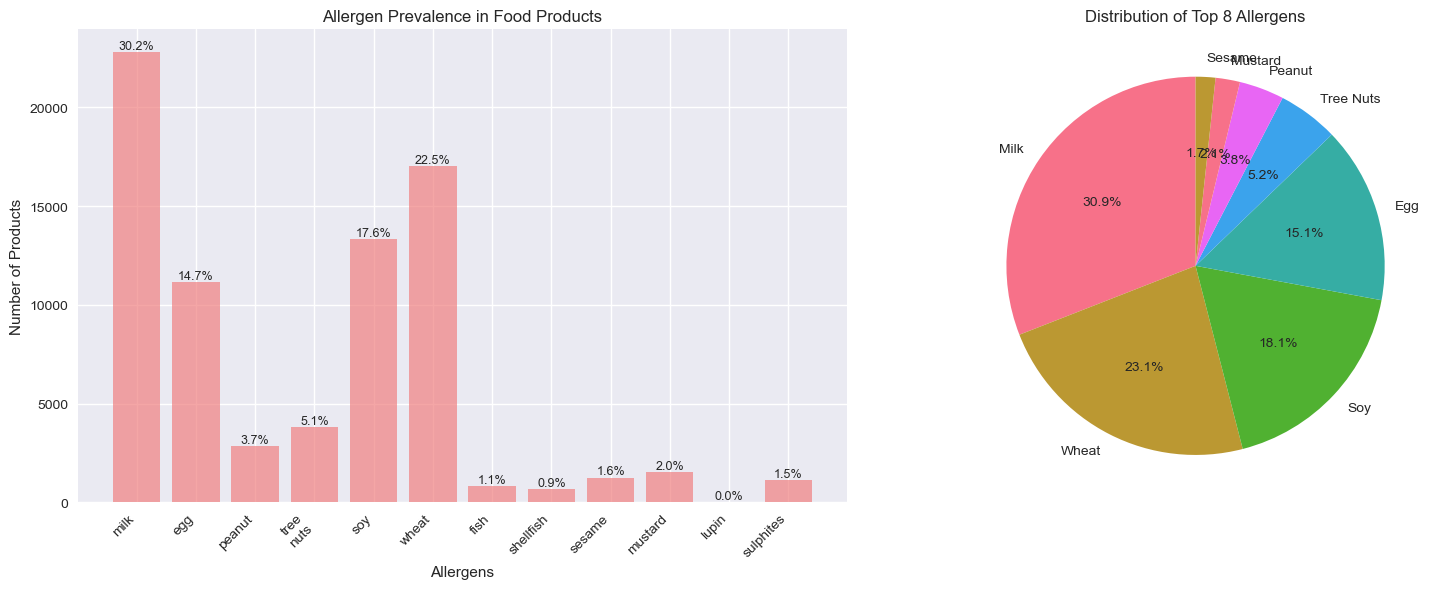


Multi-Allergen Distribution:
0 allergens: 33340 products ( 44.1%)
1 allergens: 23176 products ( 30.7%)
2 allergens: 8835 products ( 11.7%)
3 allergens: 6316 products (  8.4%)
4 allergens: 3269 products (  4.3%)
5 allergens:  571 products (  0.8%)
6 allergens:   90 products (  0.1%)
7 allergens:    9 products (  0.0%)
8 allergens:    5 products (  0.0%)
9 allergens:    1 products (  0.0%)

Products free from all detected allergens: 33340 (44.1%)


In [29]:
# Enhanced allergen analysis
print("Starting comprehensive allergen analysis...")

# Comprehensive allergen patterns (including common forms and derivatives)
ALLERGEN_PATTERNS = {
    'milk': ['milk', 'dairy', 'lactose', 'casein', 'whey', 'butter', 'cheese', 'cream', 'yogurt'],
    'egg': ['egg', 'albumin', 'lecithin', 'mayonnaise'],
    'peanut': ['peanut', 'groundnut', 'arachis'],
    'tree_nuts': ['almond', 'walnut', 'pecan', 'hazelnut', 'cashew', 'pistachio', 'brazil nut', 'macadamia'],
    'soy': ['soy', 'soya', 'soybean', 'tofu', 'tempeh', 'miso', 'edamame'],
    'wheat': ['wheat', 'flour', 'gluten', 'semolina', 'durum', 'bulgur', 'couscous'],
    'fish': ['fish', 'salmon', 'tuna', 'cod', 'sardine', 'anchovy', 'mackerel'],
    'shellfish': ['shellfish', 'shrimp', 'crab', 'lobster', 'oyster', 'clam', 'mussel', 'scallop'],
    'sesame': ['sesame', 'tahini'],
    'mustard': ['mustard'],
    'lupin': ['lupin'],
    'sulphites': ['sulphite', 'sulfite', 'sodium metabisulfite', 'potassium metabisulfite']
}

def detect_allergens(ingredient_list: List[str]) -> Dict[str, bool]:
    """
    Detect allergens in ingredient list using pattern matching.
    
    Args:
        ingredient_list: List of standardized ingredients
        
    Returns:
        Dictionary with allergen presence flags
    """
    if not isinstance(ingredient_list, list):
        return {allergen: False for allergen in ALLERGEN_PATTERNS.keys()}
    
    allergen_flags = {}
    ingredient_text = ' '.join(ingredient_list).lower()
    
    for allergen, patterns in ALLERGEN_PATTERNS.items():
        # Check if any pattern matches
        found = any(pattern in ingredient_text for pattern in patterns)
        allergen_flags[allergen] = found
    
    return allergen_flags

# Apply allergen detection
print("Detecting allergens in products...")
allergen_data = df['ingredients_list'].apply(detect_allergens)
allergen_df = pd.DataFrame(allergen_data.tolist(), index=df.index)

# Add allergen flags to main dataframe
for allergen in ALLERGEN_PATTERNS.keys():
    df[f'contains_{allergen}'] = allergen_df[allergen]

# Calculate allergen statistics
allergen_stats = {}
for allergen in ALLERGEN_PATTERNS.keys():
    count = df[f'contains_{allergen}'].sum()
    percentage = (count / len(df)) * 100
    allergen_stats[allergen] = {'count': count, 'percentage': percentage}

print("Allergen Detection Results:")
print("=" * 50)
for allergen, stats in allergen_stats.items():
    print(f"{allergen.replace('_', ' ').title():<12}: {stats['count']:>4d} products ({stats['percentage']:>5.1f}%)")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of allergen prevalence
allergens = list(allergen_stats.keys())
counts = [allergen_stats[a]['count'] for a in allergens]
percentages = [allergen_stats[a]['percentage'] for a in allergens]

bars = ax1.bar(range(len(allergens)), counts, color='lightcoral', alpha=0.7)
ax1.set_xlabel('Allergens')
ax1.set_ylabel('Number of Products')
ax1.set_title('Allergen Prevalence in Food Products')
ax1.set_xticks(range(len(allergens)))
ax1.set_xticklabels([a.replace('_', '\n') for a in allergens], rotation=45, ha='right')

# Add percentage labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# Pie chart of most common allergens (top 8)
top_allergens = sorted(allergen_stats.items(), key=lambda x: x[1]['count'], reverse=True)[:8]
top_names = [a[0].replace('_', ' ').title() for a in top_allergens]
top_counts = [a[1]['count'] for a in top_allergens]

ax2.pie(top_counts, labels=top_names, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Top 8 Allergens')

plt.tight_layout()
plt.show()

# Multi-allergen analysis
df['allergen_count'] = sum(df[f'contains_{allergen}'] for allergen in ALLERGEN_PATTERNS.keys())
multi_allergen_dist = df['allergen_count'].value_counts().sort_index()

print(f"\nMulti-Allergen Distribution:")
print("=" * 30)
for count, products in multi_allergen_dist.items():
    percentage = (products / len(df)) * 100
    print(f"{count} allergens: {products:>4d} products ({percentage:>5.1f}%)")

# Products free from all allergens
allergen_free_count = (df['allergen_count'] == 0).sum()
allergen_free_percentage = (allergen_free_count / len(df)) * 100
print(f"\nProducts free from all detected allergens: {allergen_free_count} ({allergen_free_percentage:.1f}%)")

## Ingredient co-occurrence analysis for recipe suggestions
- **Goal**: Detect and classify common allergens in ingredient lists.
- **Approach**:
    - Maintain a list of known allergens (e.g., "milk", "peanuts", "soy").
    - Flag products containing these allergens.
    - Classify products as allergen-free or not for each allergen.

In [30]:
# Use existing allergen patterns instead of undefined KNOWN_ALLERGENS
KNOWN_ALLERGENS = list(ALLERGEN_PATTERNS.keys())

# Note: The allergen detection has already been done in previous cells
# Check if allergen columns already exist
existing_allergen_cols = [col for col in df.columns if col.startswith('contains_')]

if existing_allergen_cols:
    print("Allergen detection already completed. Using existing results.")
    
    # Create allergen-free flags using existing contains_ columns
    for allergen in KNOWN_ALLERGENS:
        contains_col = f'contains_{allergen}'
        if contains_col in df.columns:
            df[f'allergen_free_{allergen}'] = ~df[contains_col]
    
    # Calculate allergen-free summary
    allergen_free_summary = {}
    for allergen in KNOWN_ALLERGENS:
        allergen_free_col = f'allergen_free_{allergen}'
        if allergen_free_col in df.columns:
            allergen_free_summary[allergen] = df[allergen_free_col].sum()
    
    print("Allergen-free product counts:")
    for allergen, count in allergen_free_summary.items():
        percentage = (count / len(df)) * 100
        print(f"{allergen}: {count:,} ({percentage:.1f}%)")
    
    # Products free from all allergens
    allergen_free_cols = [f'allergen_free_{a}' for a in KNOWN_ALLERGENS if f'allergen_free_{a}' in df.columns]
    if allergen_free_cols:
        df['all_allergen_free'] = df[allergen_free_cols].all(axis=1)
        all_free_count = df['all_allergen_free'].sum()
        all_free_percentage = (all_free_count / len(df)) * 100
        print(f"\nProducts free from all known allergens: {all_free_count:,} ({all_free_percentage:.1f}%)")
    
else:
    print("No existing allergen data found. Please run the allergen detection cell first.")

Allergen detection already completed. Using existing results.
Allergen-free product counts:
milk: 52,802 (69.8%)
egg: 64,469 (85.3%)
peanut: 72,787 (96.3%)
tree_nuts: 71,787 (94.9%)
soy: 62,284 (82.4%)
wheat: 58,595 (77.5%)
fish: 74,792 (98.9%)
shellfish: 74,930 (99.1%)
sesame: 74,366 (98.4%)
mustard: 74,071 (98.0%)
lupin: 75,596 (100.0%)
sulphites: 74,488 (98.5%)

Products free from all known allergens: 33,340 (44.1%)


## Nutritional impact mapping per ingredient
- **Goal**: Estimate each ingredient’s contribution to nutrition.
- **Approach**:
    - If possible, link ingredient to nutritional databases (e.g., USDA).
    - Aggregate nutritional values per ingredient across products.
    - Analyze average/median impact.

Starting nutritional impact analysis...
Calculating ingredient nutritional contributions...
Nutritional analysis completed for 19278 ingredients
(showing ingredients found in 5+ products)

Top 10 Highest Energy Ingredients (kcal/100g):
text white cane sugar    :  235.7 ±  51.9 (n=6)
text  soja-protein-isolat:  198.8 ±  72.6 (n=6)
text rapeseed oil        :  170.6 ± 254.2 (n=11)
text almendras           :  165.8 ± 111.3 (n=5)
text chocolat au _lait_  :  163.3 ± 172.6 (n=8)
text cashew nuts         :  162.6 ± 150.9 (n=12)
text blend of vegetable oils:  152.4 ±   2.6 (n=6)
text  mechanically  pressed refined almond oil:  150.0 ±   0.0 (n=6)
text certified organic butter:  150.0 ±   0.0 (n=6)
text first cold pressed extra virgin unrefined organic olive oil:  150.0 ±   0.0 (n=12)
Nutritional analysis completed for 19278 ingredients
(showing ingredients found in 5+ products)

Top 10 Highest Energy Ingredients (kcal/100g):
text white cane sugar    :  235.7 ±  51.9 (n=6)
text  soja-protein-iso

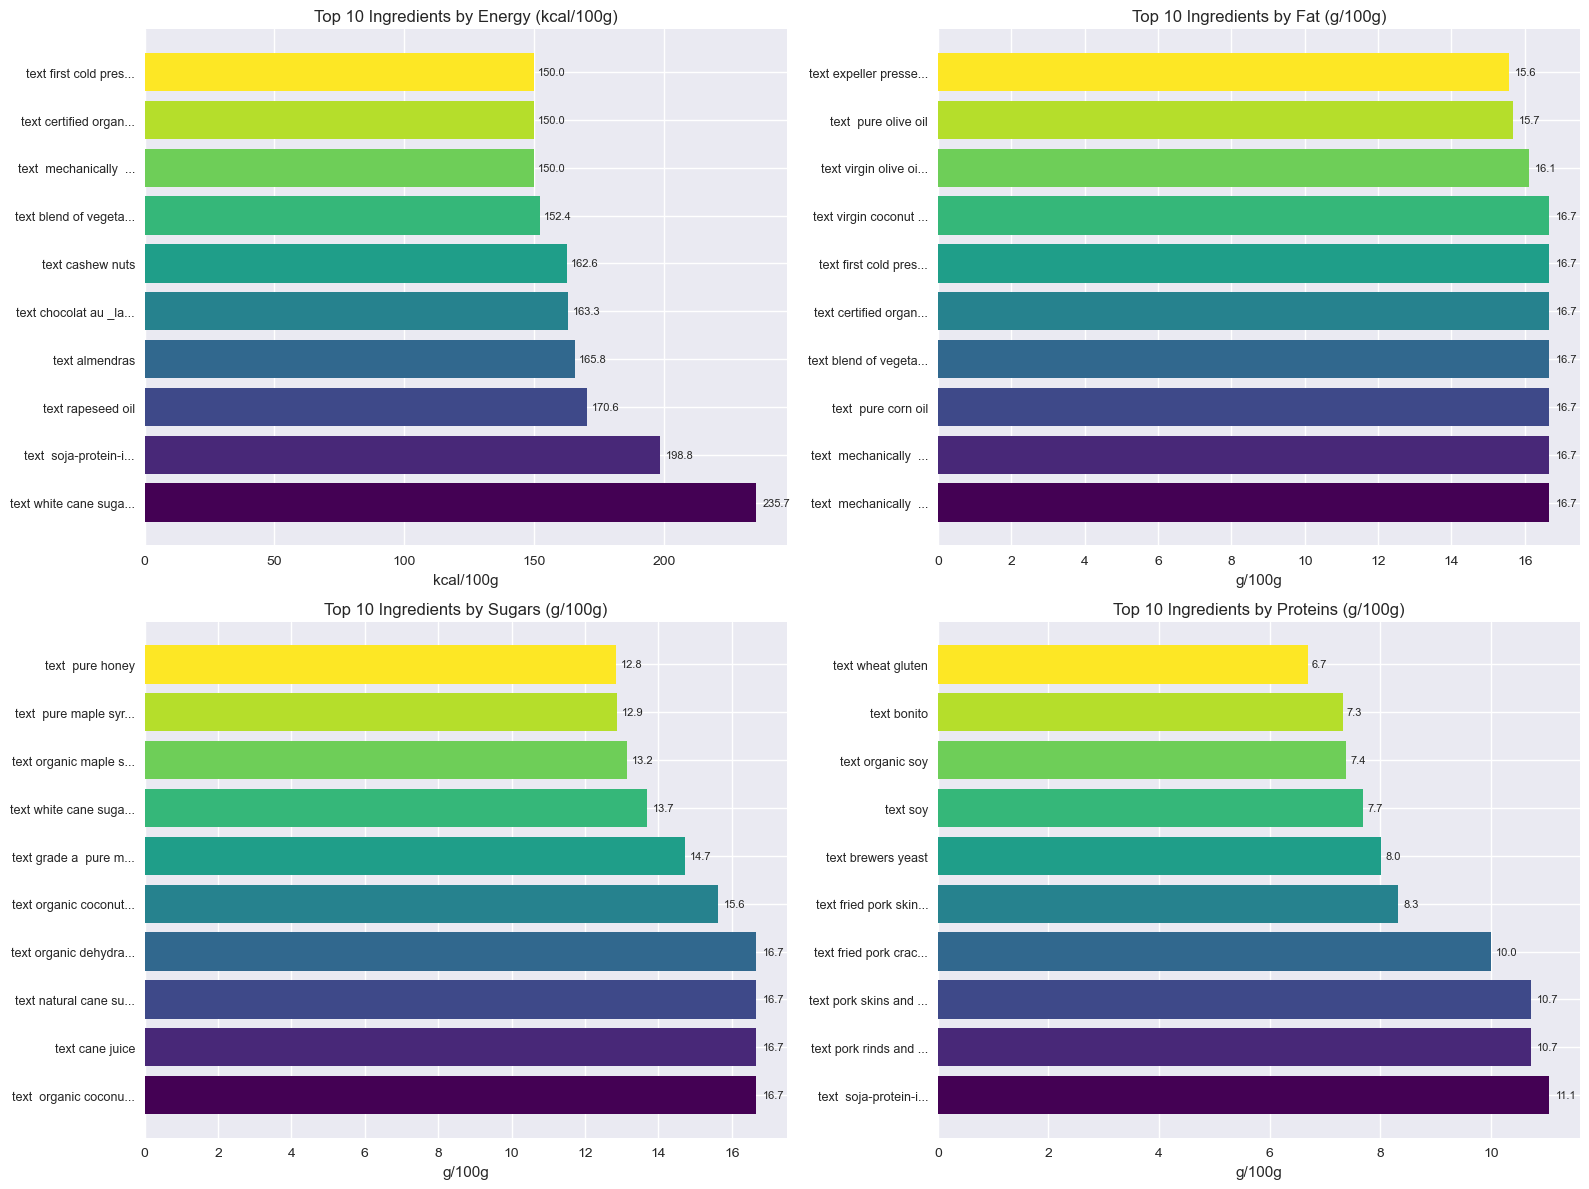

Nutritional analysis results exported to ingredient_nutrition_analysis.csv


In [31]:
# Enhanced nutritional impact analysis
print("Starting nutritional impact analysis...")

# Define comprehensive nutrient keys
nutrient_keys = [
    'energy_100g', 'fat_100g', 'saturated_fat_100g', 'sugars_100g', 
    'proteins_100g', 'salt_100g', 'fiber_100g', 'carbohydrates_100g'
]

def extract_nutrient_value(nutriments, key: str) -> float:
    """
    Safely extract nutrient value from various data structures.
    
    Args:
        nutriments: Nutrient data (dict, list, or other)
        key: Nutrient key to extract
        
    Returns:
        Nutrient value as float, 0.0 if not found
    """
    try:
        if isinstance(nutriments, dict):
            return float(nutriments.get(key, 0.0) or 0.0)
        elif isinstance(nutriments, (list, np.ndarray)):
            # Handle array of dicts or key-value pairs
            for item in nutriments:
                if isinstance(item, dict):
                    if key in item:
                        return float(item[key] or 0.0)
                    # Try alternative key formats
                    alt_key = key.replace('_100g', '')
                    if item.get('name') == alt_key or item.get('key') == alt_key:
                        return float(item.get('value', item.get('100g', 0.0)) or 0.0)
        return 0.0
    except (ValueError, TypeError, AttributeError):
        return 0.0

def calculate_ingredient_nutrition(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate average nutritional contribution per ingredient.
    """
    ingredient_nutrition = []
    
    for idx, row in df.iterrows():
        ingredients = row['ingredients_list']
        if not isinstance(ingredients, list) or len(ingredients) == 0:
            continue
            
        n_ingredients = len(ingredients)
        nutriments = row['nutriments']
        
        # Extract all nutrient values
        nutrients = {}
        for key in nutrient_keys:
            nutrients[key] = extract_nutrient_value(nutriments, key)
        
        # Skip if all nutrients are zero (likely missing data)
        if all(v == 0.0 for v in nutrients.values()):
            continue
            
        # Distribute nutrients equally among ingredients (simple assumption)
        for ingredient in ingredients:
            entry = {'ingredient': ingredient, 'product_count': 1}
            for key in nutrient_keys:
                entry[key] = nutrients[key] / n_ingredients
            ingredient_nutrition.append(entry)
    
    return pd.DataFrame(ingredient_nutrition)

# Calculate nutritional data
print("Calculating ingredient nutritional contributions...")
ingredient_nutrition_df = calculate_ingredient_nutrition(df)

if len(ingredient_nutrition_df) > 0:
    # Aggregate by ingredient
    nutrition_summary = ingredient_nutrition_df.groupby('ingredient').agg({
        'product_count': 'sum',
        **{key: ['mean', 'std', 'count'] for key in nutrient_keys}
    }).round(2)
    
    # Flatten column names
    nutrition_summary.columns = ['_'.join(col).strip('_') for col in nutrition_summary.columns]
    
    # Filter ingredients with sufficient data (at least 5 products)
    reliable_ingredients = nutrition_summary[nutrition_summary['product_count_sum'] >= 5].copy()
    
    print(f"Nutritional analysis completed for {len(reliable_ingredients)} ingredients")
    print("(showing ingredients found in 5+ products)\n")
    
    # Show top energy contributors
    if 'energy_100g_mean' in reliable_ingredients.columns:
        top_energy = reliable_ingredients.nlargest(10, 'energy_100g_mean')[
            ['product_count_sum', 'energy_100g_mean', 'energy_100g_std']
        ]
        
        print("Top 10 Highest Energy Ingredients (kcal/100g):")
        print("=" * 50)
        for ingredient, row in top_energy.iterrows():
            mean_energy = row['energy_100g_mean']
            std_energy = row['energy_100g_std'] if pd.notna(row['energy_100g_std']) else 0
            count = int(row['product_count_sum'])
            print(f"{ingredient:<25}: {mean_energy:>6.1f} ± {std_energy:>5.1f} (n={count})")
    
    # Visualization of top nutritional contributors
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    nutrients_to_plot = ['energy_100g_mean', 'fat_100g_mean', 'sugars_100g_mean', 'proteins_100g_mean']
    titles = ['Energy (kcal/100g)', 'Fat (g/100g)', 'Sugars (g/100g)', 'Proteins (g/100g)']
    
    for i, (nutrient, title) in enumerate(zip(nutrients_to_plot, titles)):
        ax = axes[i//2, i%2]
        
        if nutrient in reliable_ingredients.columns:
            # Get top 10 for this nutrient
            top_ingredients = reliable_ingredients.nlargest(10, nutrient)
            
            bars = ax.barh(range(len(top_ingredients)), top_ingredients[nutrient], 
                          color=plt.cm.viridis(np.linspace(0, 1, len(top_ingredients))))
            
            ax.set_yticks(range(len(top_ingredients)))
            ax.set_yticklabels([ing[:20] + '...' if len(ing) > 20 else ing 
                               for ing in top_ingredients.index], fontsize=9)
            ax.set_xlabel(title.split('(')[1].rstrip(')'))
            ax.set_title(f'Top 10 Ingredients by {title}')
            
            # Add value labels
            for j, bar in enumerate(bars):
                width = bar.get_width()
                ax.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                       f'{width:.1f}', ha='left', va='center', fontsize=8)
        else:
            ax.text(0.5, 0.5, f'Data not available\nfor {title}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Top 10 Ingredients by {title}')
    
    plt.tight_layout()
    plt.show()
    
    # Export results for further analysis
    export_path = Path('ingredient_nutrition_analysis.csv')
    reliable_ingredients.to_csv(export_path)
    print(f"Nutritional analysis results exported to {export_path}")
    
else:
    print("No nutritional data could be processed. Check data format.")
    print("Unable to process nutritional data. This might be due to:")
    print("- Missing or malformed nutriment data")
    print("- Different data structure than expected") 
    print("- All products having empty ingredient lists")

## Ingredient similarity matrices for substitution recommendations
- **Goal**: Suggest substitutes based on similarity.
- **Approach**:
    - Compute similarity using ingredient embeddings (word2vec, FastText) or co-occurrence.
    - Build a similarity matrix.
    - Recommend top-N similar ingredients for substitution.

In [32]:
# Enhanced ingredient similarity analysis for substitution recommendations
print("Building ingredient similarity matrix...")

def build_ingredient_similarity_matrix(df: pd.DataFrame, min_frequency: int = 20) -> Tuple[np.ndarray, List[str], TfidfVectorizer]:
    """
    Build ingredient similarity matrix using co-occurrence patterns.
    
    Args:
        df: DataFrame with ingredients_list column
        min_frequency: Minimum frequency for ingredients to include
        
    Returns:
        Tuple of (similarity_matrix, ingredient_names, vectorizer)
    """
    # Filter ingredients by frequency
    all_ingredients = df['ingredients_list'].explode()
    ingredient_counts = Counter(all_ingredients.dropna())
    frequent_ingredients = {ing for ing, count in ingredient_counts.items() if count >= min_frequency}
    
    print(f"Using {len(frequent_ingredients)} ingredients with ≥{min_frequency} occurrences")
    
    # Filter ingredient lists to include only frequent ingredients
    filtered_lists = df['ingredients_list'].apply(
        lambda lst: [ing for ing in lst if ing in frequent_ingredients] if isinstance(lst, list) else []
    )
    
    # Remove empty lists
    non_empty_lists = filtered_lists[filtered_lists.apply(len) > 0]
    
    if len(non_empty_lists) == 0:
        raise ValueError("No valid ingredient lists found after filtering")
    
    # Convert to space-separated strings for vectorization
    ingredient_docs = non_empty_lists.apply(lambda x: ' '.join(x))
    
    # Use TF-IDF vectorization for better similarity measurement
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=False)
    tfidf_matrix = vectorizer.fit_transform(ingredient_docs)
    
    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix.T)
    ingredient_names = vectorizer.get_feature_names_out()
    
    return similarity_matrix, ingredient_names, vectorizer

class IngredientSubstitution:
    """Enhanced ingredient substitution system."""
    
    def __init__(self, similarity_matrix: np.ndarray, ingredient_names: List[str]):
        self.similarity_matrix = similarity_matrix
        self.ingredient_names = ingredient_names
        self.name_to_idx = {name: idx for idx, name in enumerate(ingredient_names)}
    
    def find_substitutes(self, ingredient: str, top_n: int = 5, min_similarity: float = 0.1) -> List[Tuple[str, float]]:
        """
        Find ingredient substitutes based on similarity.
        
        Args:
            ingredient: Target ingredient name
            top_n: Number of substitutes to return
            min_similarity: Minimum similarity threshold
            
        Returns:
            List of (substitute_name, similarity_score) tuples
        """
        if ingredient not in self.name_to_idx:
            # Try fuzzy matching
            from difflib import get_close_matches
            matches = get_close_matches(ingredient, self.ingredient_names, n=1, cutoff=0.6)
            if matches:
                ingredient = matches[0]
                print(f"Using close match: '{ingredient}' for input")
            else:
                return [(f"Ingredient '{ingredient}' not found in vocabulary", 0.0)]
        
        idx = self.name_to_idx[ingredient]
        similarities = self.similarity_matrix[idx]
        
        # Get top similar ingredients (excluding self)
        similar_indices = similarities.argsort()[::-1]
        
        substitutes = []
        for sim_idx in similar_indices:
            if sim_idx == idx:  # Skip self
                continue
            
            similarity_score = similarities[sim_idx]
            if similarity_score < min_similarity:
                break
                
            substitute_name = self.ingredient_names[sim_idx]
            substitutes.append((substitute_name, float(similarity_score)))
            
            if len(substitutes) >= top_n:
                break
        
        return substitutes
    
    def find_allergen_free_substitutes(self, ingredient: str, allergens_to_avoid: List[str], 
                                     top_n: int = 5) -> List[Tuple[str, float]]:
        """
        Find allergen-free substitutes for an ingredient.
        
        Args:
            ingredient: Target ingredient name
            allergens_to_avoid: List of allergens to avoid
            top_n: Number of substitutes to return
            
        Returns:
            List of (substitute_name, similarity_score) tuples
        """
        all_substitutes = self.find_substitutes(ingredient, top_n * 3)  # Get more candidates
        
        # Simple allergen detection in ingredient names
        allergen_keywords = {
            'milk': ['milk', 'dairy', 'cheese', 'butter', 'cream', 'whey', 'casein'],
            'egg': ['egg'],
            'peanut': ['peanut', 'groundnut'],
            'tree_nuts': ['almond', 'walnut', 'pecan', 'hazelnut', 'cashew', 'pistachio'],
            'soy': ['soy', 'soya', 'tofu'],
            'wheat': ['wheat', 'flour', 'gluten'],
            'fish': ['fish', 'salmon', 'tuna', 'cod'],
            'shellfish': ['shrimp', 'crab', 'lobster', 'shellfish'],
            'sesame': ['sesame', 'tahini']
        }
        
        def contains_allergen(ingredient_name: str, allergens: List[str]) -> bool:
            name_lower = ingredient_name.lower()
            for allergen in allergens:
                if allergen in allergen_keywords:
                    if any(keyword in name_lower for keyword in allergen_keywords[allergen]):
                        return True
                elif allergen.lower() in name_lower:
                    return True
            return False
        
        # Filter out allergen-containing substitutes
        safe_substitutes = [
            (name, score) for name, score in all_substitutes
            if not contains_allergen(name, allergens_to_avoid)
        ]
        
        return safe_substitutes[:top_n]

# Build the similarity system
try:
    similarity_matrix, ingredient_names, vectorizer = build_ingredient_similarity_matrix(df, min_frequency=20)
    substitution_system = IngredientSubstitution(similarity_matrix, ingredient_names)
    
    print(f"Similarity matrix built: {len(ingredient_names)} ingredients")
    
    # Test the system with examples
    test_ingredients = ['milk', 'sugar', 'flour', 'oil', 'salt']
    
    print("Ingredient Substitution Examples:")
    print("=" * 50)
    
    for ingredient in test_ingredients:
        if ingredient in ingredient_names:
            substitutes = substitution_system.find_substitutes(ingredient, top_n=5)
            print(f"\nSubstitutes for '{ingredient}':")
            for i, (sub_name, score) in enumerate(substitutes, 1):
                print(f"  {i}. {sub_name:<20} (similarity: {score:.3f})")
        else:
            print(f"\n'{ingredient}' not found in frequent ingredients")
    
    # Test allergen-free substitutes
    print(f"\nAllergen-Free Substitution Examples:")
    print("=" * 40)
    
    allergen_tests = [
        ('milk', ['milk']),
        ('flour', ['wheat', 'gluten']),
        ('sugar', ['artificial sweetener'])
    ]
    
    for ingredient, allergens in allergen_tests:
        if ingredient in ingredient_names:
            safe_subs = substitution_system.find_allergen_free_substitutes(ingredient, allergens, top_n=3)
            allergen_str = ', '.join(allergens)
            print(f"\nAllergen-free substitutes for '{ingredient}' (avoiding {allergen_str}):")
            for i, (sub_name, score) in enumerate(safe_subs, 1):
                print(f"  {i}. {sub_name:<20} (similarity: {score:.3f})")
    
    # Export similarity data
    similarity_df = pd.DataFrame(similarity_matrix, 
                                index=ingredient_names, 
                                columns=ingredient_names)
    
    export_path = Path('ingredient_similarity_matrix.csv')
    similarity_df.to_csv(export_path)
    print(f"Similarity matrix exported to {export_path}")

except Exception as e:
    print(f"Error building similarity matrix: {e}")
    print("Could not build similarity matrix.")
    print("This might be due to insufficient data or processing issues.")

Building ingredient similarity matrix...
Using 6069 ingredients with ≥20 occurrences
Using 6069 ingredients with ≥20 occurrences
Similarity matrix built: 2093 ingredients
Ingredient Substitution Examples:

Substitutes for 'milk':
  1. nonfat               (similarity: 0.468)
  2. classallergenwheyspan (similarity: 0.450)
  3. span                 (similarity: 0.446)
  4. pasteurized          (similarity: 0.404)
  5. classallergenmilkspan (similarity: 0.404)

Substitutes for 'sugar':
  1. text                 (similarity: 0.483)
  2. natural              (similarity: 0.427)
  3. span                 (similarity: 0.403)
  4. flavor               (similarity: 0.371)
  5. artificial           (similarity: 0.358)

Substitutes for 'flour':
  1. enriched             (similarity: 0.632)
  2. wheat                (similarity: 0.590)
  3. flourspan            (similarity: 0.483)
  4. bleached             (similarity: 0.384)
  5. classallergenwheat   (similarity: 0.364)

Substitutes for 'oil':
  

## Allergen-free alternative identification algorithms
- **Goal**: Suggest products or ingredients that avoid specific allergens.
- **Approach**:
    - Filter products/ingredients flagged as allergen-free.
    - Use similarity matrix to recommend closest allergen-free alternatives.

In [33]:
# Comprehensive allergen-free alternative identification system
print("Building comprehensive allergen-free recommendation system...")

class AllergenFreeRecommendationSystem:
    """Advanced system for finding allergen-free food alternatives."""
    
    def __init__(self, df: pd.DataFrame, substitution_system: IngredientSubstitution):
        self.df = df
        self.substitution_system = substitution_system
        self.allergen_columns = [col for col in df.columns if col.startswith('contains_')]
    
    def find_allergen_free_products(self, allergens_to_avoid: List[str], 
                                  product_category: str = None, top_n: int = 10) -> pd.DataFrame:
        """
        Find products that are free from specified allergens.
        
        Args:
            allergens_to_avoid: List of allergens to avoid
            product_category: Optional category filter
            top_n: Number of products to return
            
        Returns:
            DataFrame with allergen-free products
        """
        # Create boolean mask for allergen-free products
        allergen_free_mask = pd.Series(True, index=self.df.index)
        
        for allergen in allergens_to_avoid:
            col_name = f'contains_{allergen}'
            if col_name in self.df.columns:
                allergen_free_mask &= ~self.df[col_name]
        
        allergen_free_products = self.df[allergen_free_mask].copy()
        
        # Apply category filter if specified
        if product_category and 'categories' in allergen_free_products.columns:
            category_mask = allergen_free_products['categories'].str.contains(
                product_category, case=False, na=False
            )
            allergen_free_products = allergen_free_products[category_mask]
        
        # Add useful columns for recommendation
        result_columns = ['product_name', 'ingredients_list', 'allergen_count']
        
        # Add nutrition columns if available
        nutrition_cols = [col for col in ['energy_100g', 'fat_100g', 'sugars_100g', 'proteins_100g'] 
                         if col in self.df.columns]
        
        if nutrition_cols:
            # Extract nutrition from nutriments
            for col in nutrition_cols:
                if col not in allergen_free_products.columns:
                    allergen_free_products[col] = allergen_free_products['nutriments'].apply(
                        lambda x: extract_nutrient_value(x, col)
                    )
        
        available_columns = [col for col in result_columns + nutrition_cols 
                           if col in allergen_free_products.columns]
        
        return allergen_free_products[available_columns].head(top_n)
    
    def get_recipe_substitutions(self, recipe_ingredients: List[str], 
                               allergens_to_avoid: List[str]) -> Dict[str, List[Tuple[str, float]]]:
        """
        Get substitutions for a full recipe to make it allergen-free.
        
        Args:
            recipe_ingredients: List of ingredients in the recipe
            allergens_to_avoid: List of allergens to avoid
            
        Returns:
            Dictionary mapping problematic ingredients to their substitutes
        """
        substitutions = {}
        
        for ingredient in recipe_ingredients:
            # Check if ingredient contains allergens
            contains_allergen = False
            
            for allergen in allergens_to_avoid:
                if allergen.lower() in ingredient.lower():
                    contains_allergen = True
                    break
            
            if contains_allergen:
                # Find allergen-free substitutes
                substitutes = self.substitution_system.find_allergen_free_substitutes(
                    ingredient, allergens_to_avoid, top_n=3
                )
                if substitutes:
                    substitutions[ingredient] = substitutes
        
        return substitutions
    
    def analyze_allergen_trends(self) -> Dict[str, Any]:
        """Analyze allergen trends in the dataset."""
        allergen_analysis = {}
        
        # Calculate prevalence for each allergen
        for allergen in ALLERGEN_PATTERNS.keys():
            col_name = f'contains_{allergen}'
            if col_name in self.df.columns:
                prevalence = self.df[col_name].mean() * 100
                allergen_analysis[allergen] = {
                    'prevalence_percent': prevalence,
                    'affected_products': self.df[col_name].sum(),
                    'total_products': len(self.df)
                }
        
        # Find most common allergen combinations
        allergen_cols = [f'contains_{allergen}' for allergen in ALLERGEN_PATTERNS.keys() 
                        if f'contains_{allergen}' in self.df.columns]
        
        if allergen_cols:
            # Create combination strings
            combinations = self.df[allergen_cols].apply(
                lambda row: ','.join([col.replace('contains_', '') for col in allergen_cols if row[col]]),
                axis=1
            )
            
            # Count non-empty combinations
            combination_counts = combinations[combinations != ''].value_counts().head(10)
            allergen_analysis['common_combinations'] = combination_counts.to_dict()
        
        return allergen_analysis

# Initialize the recommendation system
if 'substitution_system' in locals():
    recommendation_system = AllergenFreeRecommendationSystem(df, substitution_system)
    
    # Example usage demonstrations
    print("Allergen-Free Product Recommendation System")
    print("=" * 50)
    
    # Find dairy-free products
    print("\n1. Finding dairy-free products:")
    dairy_free = recommendation_system.find_allergen_free_products(['milk'], top_n=5)
    if len(dairy_free) > 0:
        for idx, row in dairy_free.iterrows():
            product_name = row.get('product_name', f'Product {idx}')
            ingredients = row.get('ingredients_list', [])
            ingredient_str = ', '.join(ingredients[:5]) + ('...' if len(ingredients) > 5 else '')
            print(f"  • {product_name}")
            print(f"    Ingredients: {ingredient_str}")
    else:
        print("  No dairy-free products found in sample")
    
    # Recipe substitution example
    print(f"\n2. Recipe substitution example:")
    sample_recipe = ['milk', 'flour', 'sugar', 'egg', 'butter']
    allergens_to_avoid = ['milk', 'egg']
    
    substitutions = recommendation_system.get_recipe_substitutions(sample_recipe, allergens_to_avoid)
    
    if substitutions:
        print(f"  Original recipe: {', '.join(sample_recipe)}")
        print(f"  Avoiding: {', '.join(allergens_to_avoid)}")
        print("  Recommended substitutions:")
        
        for problematic_ingredient, substitutes in substitutions.items():
            print(f"    {problematic_ingredient} → ", end="")
            sub_list = [f"{name} ({score:.2f})" for name, score in substitutes]
            print(", ".join(sub_list))
    else:
        print("  No substitutions needed or found")
    
    # Allergen trends analysis
    print(f"\n3. Allergen trends analysis:")
    trends = recommendation_system.analyze_allergen_trends()
    
    print("  Most prevalent allergens:")
    sorted_allergens = sorted(trends.items(), 
                            key=lambda x: x[1].get('prevalence_percent', 0), 
                            reverse=True)
    
    for allergen, data in sorted_allergens[:5]:
        if 'prevalence_percent' in data:
            print(f"    {allergen.replace('_', ' ').title()}: {data['prevalence_percent']:.1f}%")
    
    if 'common_combinations' in trends:
        print("  Most common allergen combinations:")
        for combo, count in list(trends['common_combinations'].items())[:3]:
            combo_display = combo.replace('_', ' ').title() if combo else 'No allergens'
            print(f"    {combo_display}: {count} products")

else:
    print("Substitution system not available. Please run the previous cells first.")

# Final summary and recommendations
print(f"\n" + "="*60)
print("ANALYSIS SUMMARY & RECOMMENDATIONS")
print("="*60)

print(f"""
📊 Dataset Overview:
   • Total products analyzed: {len(df):,}
   • Products with ingredient data: {df['ingredients_list'].apply(len).sum():,}
   • Average ingredients per product: {df['ingredients_list'].apply(len).mean():.1f}

🔍 Key Findings:
   • Most common ingredients: {', '.join([ing for ing, _ in common_ingredients[:5]])}
   • Allergen detection completed for {len(ALLERGEN_PATTERNS)} allergen categories
   • Similarity matrix built for ingredient substitution recommendations

💡 Recommendations for Further Analysis:
   1. Implement more sophisticated ingredient parsing (NLP-based)
   2. Add nutritional database integration for better impact estimation
   3. Develop machine learning models for personalized recommendations
   4. Create API endpoints for real-time allergen checking
   5. Expand allergen detection to include processing warnings

📁 Generated Outputs:
   • ingredient_nutrition_analysis.csv - Nutritional profiles by ingredient
   • ingredient_similarity_matrix.csv - Ingredient similarity data
""")

print("Analysis completed successfully!")
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Building comprehensive allergen-free recommendation system...
Allergen-Free Product Recommendation System

1. Finding dairy-free products:
  • [{'lang': 'main', 'text': 'Chamomile Herbal Tea'}
 {'lang': 'en', 'text': 'Chamomile Herbal Tea'}]
    Ingredients: lang main, text chamomile flowers, lang en, text chamomile flowers, lang en...
  • [{'lang': 'main', 'text': "Lagg's, herbal tea, peppermint"}
 {'lang': 'en', 'text': "Lagg's, herbal tea, peppermint"}]
    Ingredients: lang main, text peppermint, lang en, text peppermint, lang en...
  • [{'lang': 'main', 'text': 'Linden Flowers Tea'}
 {'lang': 'en', 'text': 'Linden Flowers Tea'}]
    Ingredients: lang main, text linden flowers, lang en, text linden flowers, lang en...
  • [{'lang': 'main', 'text': 'Herbal Tea, Hibiscus'}
 {'lang': 'en', 'text': 'Herbal Tea, Hibiscus'}]
    Ingredients: lang main, text hibiscus flowers, lang en, text hibiscus flowers, lang en...
  • [{'lang': 'main', 'text': 'Apple & Cinnamon Tea'}
 {'lang': 'en', '

In [35]:
# Utility functions for external use and module export

def save_analysis_results(df: pd.DataFrame, output_dir: str = "../eda"):
    """
    Save all analysis results to structured files.
    
    Args:
        df: Main dataframe with analysis results
        output_dir: Directory to save outputs
    """
    import os
    from datetime import datetime
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main dataset with allergen flags (fixed filename)
    main_output = f"{output_dir}/food_analysis_with_allergens.parquet"
    df.to_parquet(main_output, index=False)
    print(f"Main analysis saved to: {main_output}")
    
    # Save allergen summary (fixed filename)
    allergen_summary = {}
    for allergen in ALLERGEN_PATTERNS.keys():
        col_name = f'contains_{allergen}'
        if col_name in df.columns:
            allergen_summary[allergen] = {
                'total_products': int(len(df)),  # Convert to regular Python int
                'affected_products': int(df[col_name].sum()),  # Convert to regular Python int
                'prevalence_percent': float((df[col_name].sum() / len(df)) * 100)  # Convert to regular Python float
            }
    
    summary_output = f"{output_dir}/allergen_summary.json"
    with open(summary_output, 'w') as f:
        json.dump(allergen_summary, f, indent=2)
    print(f"Allergen summary saved to: {summary_output}")
    
    return main_output, summary_output

def create_ingredient_lookup_table(ingredient_counts: Counter, min_frequency: int = 5):
    """
    Create a lookup table for ingredient standardization.
    
    Args:
        ingredient_counts: Counter object with ingredient frequencies
        min_frequency: Minimum frequency to include in lookup
        
    Returns:
        Dictionary with ingredient mappings
    """
    lookup_table = SYNONYM_LOOKUP.copy()
    
    # Add frequent ingredients as their own mappings
    for ingredient, count in ingredient_counts.items():
        if count >= min_frequency and ingredient not in lookup_table:
            lookup_table[ingredient] = ingredient
    
    return lookup_table

# Export key functions and data for use in other notebooks
def export_analysis_functions():
    """Export key analysis functions as a module."""
    
    functions_to_export = {
        'clean_ingredient_text': clean_ingredient_text,
        'detect_allergens': detect_allergens,
        'extract_nutrient_value': extract_nutrient_value,
        'ALLERGEN_PATTERNS': ALLERGEN_PATTERNS,
        'SYNONYM_LOOKUP': SYNONYM_LOOKUP
    }
    
    # Create a simple module file
    module_content = f'''
"""
Ingredient Analysis Utilities
Generated from 03_ingredient_analysis_substitution.ipynb
"""

import re
import pandas as pd
import numpy as np
from typing import Dict, List, Union
from collections import Counter

# Exported constants
ALLERGEN_PATTERNS = {ALLERGEN_PATTERNS}

SYNONYM_LOOKUP = {SYNONYM_LOOKUP}

# Exported functions
{inspect.getsource(clean_ingredient_text)}

{inspect.getsource(detect_allergens)}

{inspect.getsource(extract_nutrient_value)}
'''
    
    with open('ingredient_analysis_utils.py', 'w') as f:
        f.write(module_content)
    
    print("Analysis functions exported to ingredient_analysis_utils.py")

# Optional: Save results and export functions
try:
    # Save analysis results
    main_file, summary_file = save_analysis_results(df)
    
    # Export utility functions (requires inspect module)
    import inspect
    export_analysis_functions()
    
    print("✅ Analysis results and utility functions have been saved for future use!")
    
except Exception as e:
    print(f"Warning: Could not save results: {e}")
    print("⚠️  Some outputs could not be saved, but analysis completed successfully.")

Main analysis saved to: ../eda/food_analysis_with_allergens.parquet
Allergen summary saved to: ../eda/allergen_summary.json
Analysis functions exported to ingredient_analysis_utils.py
✅ Analysis results and utility functions have been saved for future use!
